Modifications to VBI_scattering.ipynb

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import torch, time, copy, os, warnings
import seaborn as sns, tqdm, pickle as pkl
from torch.distributions import Normal, Uniform
from scipy.special import psi, gamma
from scipy.misc import derivative
from vbi_elbo2 import MCElboMF

## Data Loading Utilities

In [2]:
import sys; sys.path.append('./')
from scattering_data import DataLoader

## PyTorch Utilities

In [3]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

## Load the data

In [4]:
# Load the data
names = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']
data_train = DataLoader(0.676, 4.342, 'som')
gauss_prior_f = data_train.get_normalization_priors()
print(data_train.data.shape) 
# Data now has all values precomputed. Has the structure
# data = [E_lab, theta, cs, error, normalization group (energy bin), 
#         interaction region, k, kc, eta, H_real, H_imag, C0_2, C1_2, cs_LO]

(398, 14)


In [5]:
# # Generate l_som
# l_som = np.zeros((3, np.unique(data_train.data[:, 4]).shape[0]), dtype=int)
# for i in range(data_train.data.shape[0]):
#     l_som[data_train.data[i, 5].astype(int), data_train.data[i, 4].astype(int)] += 1

### MF - gaussian priors

## Training/Calibration Loop

### ELBO Optimization - MF Gaussian

In [6]:
# torch.manual_seed(2)

# ### Data 
# x_train = torch.tensor(data_train.theta_cs)
# y_train = torch.tensor(data_train.cs_data)

# ### torch.nn.Module class instance
# nMC = 5
# param_dim = 6
# x_dim = 1
# #model = MCElboMF(nMC = nMC, x_dim = x_dim,
# #                 param_dim = param_dim,
# #                 f_dim = data_train.f_bounds.shape[0],
# #                 err_cs = data_train.err_cs,
# #                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
# #                 which_data = "both", barnard_Elab = data_train.barnard_Elab, l_som = data_train.l_som)

# model = MCElboMF(nMC = nMC, x_dim = x_dim,
#                  param_dim = param_dim,
#                  f_dim = data_train.f_bounds.shape[0],
#                  err_cs = data_train.err_cs,
#                  Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
#                  which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

# learning_rate = 5e-2
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# n_steps = 12000
# # Saving intermediate results
# loss_array = np.zeros(n_steps)
# time_array = np.zeros(n_steps)
# param_dictionary = {}
# for name, param in model.named_parameters():
#     param_dictionary[name] = []
    
# startTime = time.time()
# for t in range(n_steps):
#     # Compute prediction
#     loss = - model.compute_elbo_loop(x_train, y_train)
#     # Zero gradinets
#     optimizer.zero_grad()
#     # Compute gradients
#     loss.backward()
#     optimizer.step()
    
#     # Utiliti computation
#     loss_array[t] = loss.item()
#     time_array[t] = time.time() - startTime 
    
#     if t % 10 == 9: 
#         for name, param in model.named_parameters():
#             param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
#     if t % 100 == 99:
#         print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
#         print(model.ModelString())
#         # Time estimmate
#         print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

# endTime = time.time()
# print(endTime - startTime)

In [7]:
torch.manual_seed(2)

### Data
x_train = torch.tensor(data_train.data[:, 1])
y_train = torch.tensor(data_train.data[:, 2])

### torch.nn.Module class instance
nMC = 5
param_dim = 6
f_dim = np.unique(data_train.data[:, 4]).shape[0]
x_dim = 1
model = MCElboMF(nMC, x_dim, param_dim, f_dim, err_cs = data_train.data[:, 3], 
                 Elab_cs = data_train.data[:, 0], f_sigmas = gauss_prior_f[:, 3], 
                 use_theory_cov = True, data_train = data_train)


learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 25000


/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/vbi_elbo2.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Hvalue_cs_real = torch.tensor(self.Hvalue_cs.real)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/vbi_elbo2.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Hvalue_cs_imag = torch.tensor(self.Hvalue_cs.imag)


In [8]:

# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []

start_time = time.time()
for t in range(0, n_steps):
    # Compute prediction
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradients
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Optimize
    optimizer.step()

    # Utility computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - start_time

    if t % 10 == 9:
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]

    if t % 100 == 99:
        print("Loss: {}, Step [{}/{}]".format(loss.item(), t, n_steps))
        # print(model.ModelString())
        # Time estimate
        print("Minutes remaining: {}".format((time.time() - start_time) * (n_steps - t) / (t * 60)))

endTime = time.time()
print(endTime - start_time)

Loss: 4992.72802734375, Step [99/25000]
Minutes remaining: 2.048506904932786
Loss: 6452.6943359375, Step [199/25000]
Minutes remaining: 1.9029244650548427
Loss: 12989.7490234375, Step [299/25000]
Minutes remaining: 1.8188724160194396
Loss: 7018.3876953125, Step [399/25000]
Minutes remaining: 1.8822478909241527
Loss: 4060.98193359375, Step [499/25000]
Minutes remaining: 1.92417394632328
Loss: 3931.461669921875, Step [599/25000]
Minutes remaining: 2.0078174644333826
Loss: 3278.061767578125, Step [699/25000]
Minutes remaining: 2.0140331702341507
Loss: 6694.61865234375, Step [799/25000]
Minutes remaining: 1.9892822946565172
Loss: 3902.645751953125, Step [899/25000]
Minutes remaining: 1.948597247573151
Loss: 2835.26123046875, Step [999/25000]
Minutes remaining: 1.9265783783591586
Loss: 2594.174560546875, Step [1099/25000]
Minutes remaining: 1.900036059204723
Loss: 2974.20751953125, Step [1199/25000]
Minutes remaining: 1.8822062540922624
Loss: 2580.377197265625, Step [1299/25000]
Minutes rem

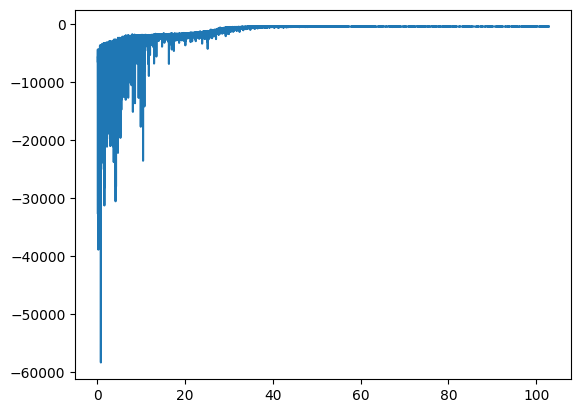

In [9]:
# ELBO
plt.plot(time_array[10:], -loss_array[10:])
plt.show()

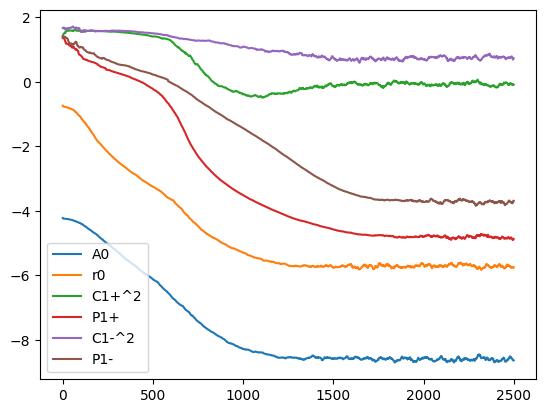

In [10]:
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

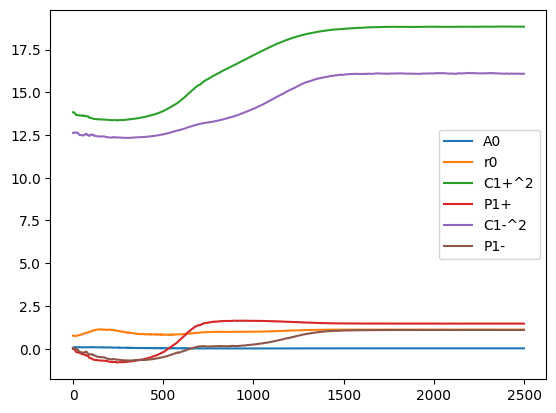

In [11]:
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/Users/andrius/ohiou/research/VBI_Pytorch_3HEscattering/venv/lib/python3.12/site-packages/seaborn/axisg

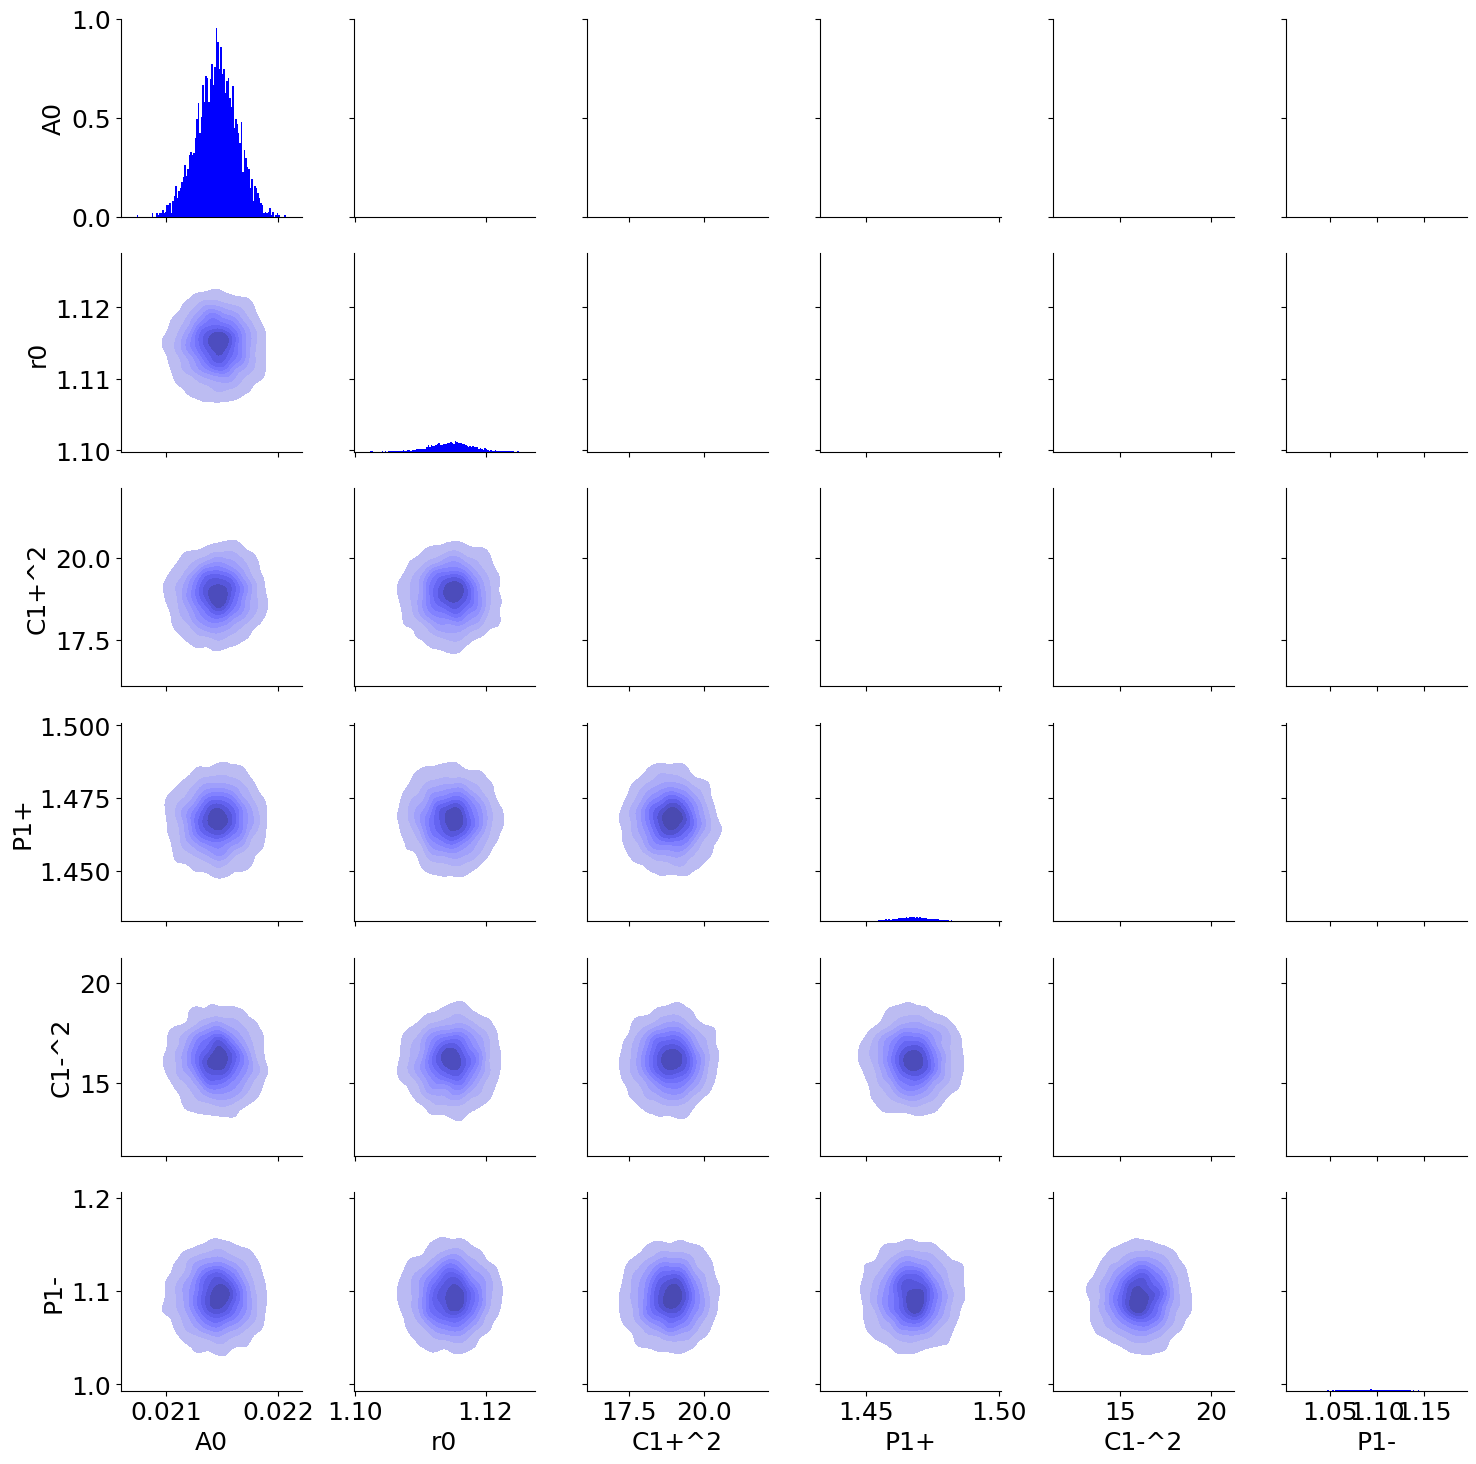

In [12]:
# VI Posteriors
model.nMC = 3000
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh = 0.05, color = "blue")
plt.show()

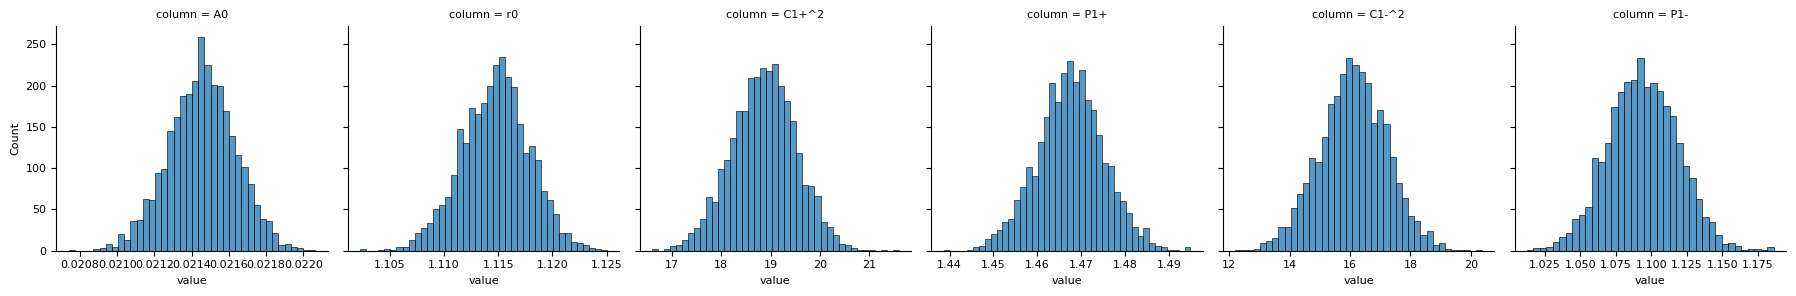

In [13]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 8})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(sns.histplot, 'value')
plt.show()

In [14]:
samples.median(axis = 0)

A0        0.021457
r0        1.114815
C1+^2    18.879612
P1+       1.467505
C1-^2    16.106480
P1-       1.093708
dtype: float64

------------

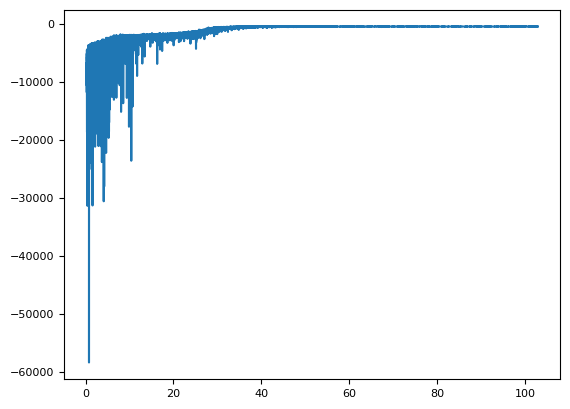

In [15]:
# ELBO
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
plt.plot(time_array[50:], -loss_array[50:])
plt.show()

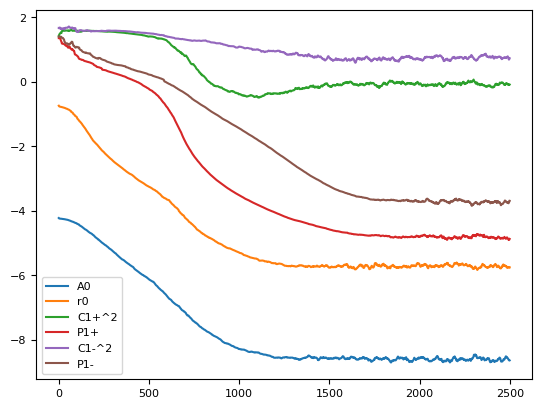

In [16]:
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

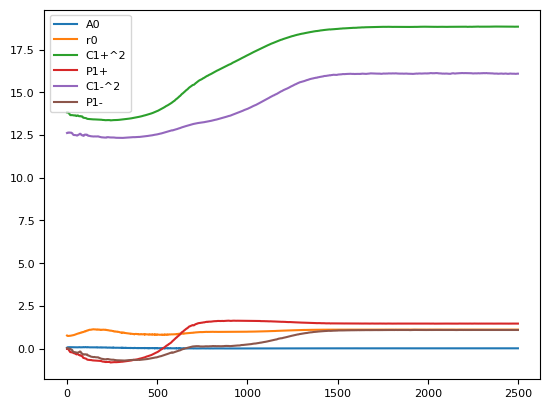

In [17]:
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

In [18]:
plt.plot(np.array(param_dictionary["q_theta_c"])[:,0,:])
plt.show()

KeyError: 'q_theta_c'

In [ ]:
L = model.cholesky_factor()
S = L @ L.T
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 9})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3), vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(pd.DataFrame(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[:6,:6], columns = names, index = names), vmin=-1, vmax=1, annot=True, cmap=cmap)
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[6:,6:], vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

In [ ]:
# VI Posteriors
model.nMC = 1500
L = model.cholesky_factor()
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, L) 

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()

In [ ]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(sns.histplot, 'value')
plt.show()